<h1 style = "font-size:3rem;color:darkcyan"> MFCC - Mel Frequency Cepstrum Coefficient</h1>

MFCC are often used for speaker/speech recognition. 

The timbre of speech is dependend on how it is filtered by the shape of the vocal tract (lips, tongue, nosal cavity, etc.). This shape is related to the envelope of the short time power spectrum, which can be represented by the mel frequency cepstrum coefficient (MFCC)

In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import scipy as sp
from scipy import signal

In [106]:
# import audio
signal , sample_rate = librosa.load('../samples/Trumpet.wav')

<h3 style = "font-size:3rem;color:darkcyan">Mel-frequency</h3>
Short time fourier transform, or spectrogram, does not quite represent audio features as humans perceive them as.
Ideally we want to have audio features in which only the relevant information of both frequency and amplitude is presented. Meaning both frequnecy and amplitude should be represented logarithmically.

We can transform frequency in such a way that each step has the same perceptual distance by transforming it to Mel-frequency. 
calculation: $m = 2595 \cdot log(1 + \frac{f}{700})$


Text(0.5, 1.0, 'Zoomed In')

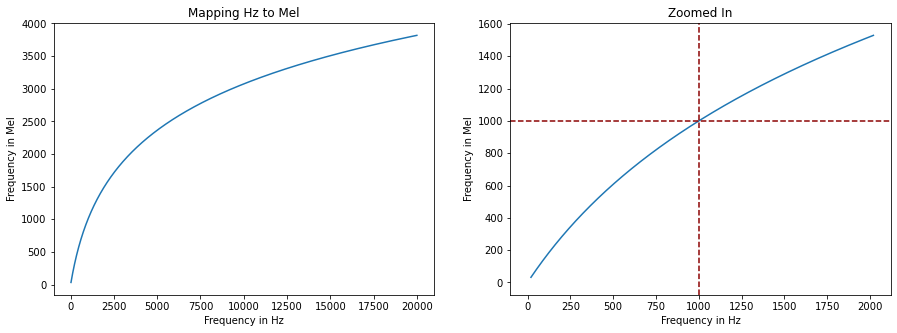

In [107]:
# Mapping:
f = np.arange(20,20000) # 20Hz to 20kHz
m = 2595 * np.log10(1 + f / 700)
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.plot(f,m)
plt.xlabel('Frequency in Hz')
plt.ylabel('Frequency in Mel')
plt.title('Mapping Hz to Mel')

plt.subplot(1,2,2)
plt.plot(f[:2000],m[:2000]) # zoomed in
plt.axline((1000,0),(1000,1000), linestyle ='--', color='darkred')
plt.axline((0,1000),(1000,1000), linestyle ='--', color='darkred')
plt.xlabel('Frequency in Hz')
plt.ylabel('Frequency in Mel')
plt.title('Zoomed In')

<h3 style = "font-size:3rem;color:darkcyan">Convert Spectrogram to Mel-frequency</h3>

1. choose number of mel bands
2. construct mel filter banks
3. apply filter banks to spectrogram

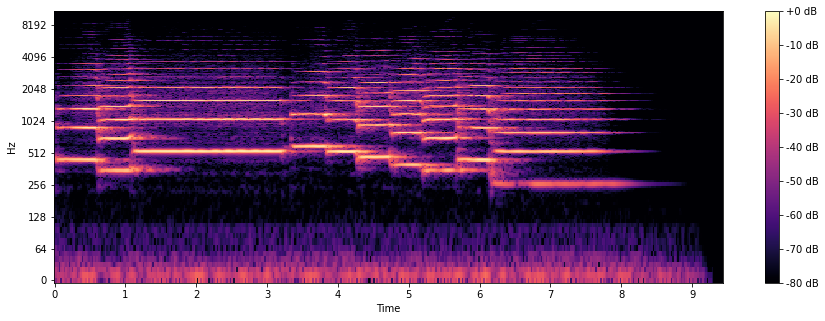

In [108]:
# Create spectrogram
plt.figure(figsize=(15, 5))
STFT = librosa.stft(signal, n_fft=2048) # return two vectors: magnitude and phase
STFT_db = librosa.amplitude_to_db(abs(STFT), ref=np.max)
img = librosa.display.specshow(STFT_db,
                                       y_axis='log',
                                       x_axis='time', 
                                       )
plt.colorbar(img, format='%+2.0f dB')

In [296]:
# Choose number of mel bands, often between 40 - 140
number_of_mels = 20

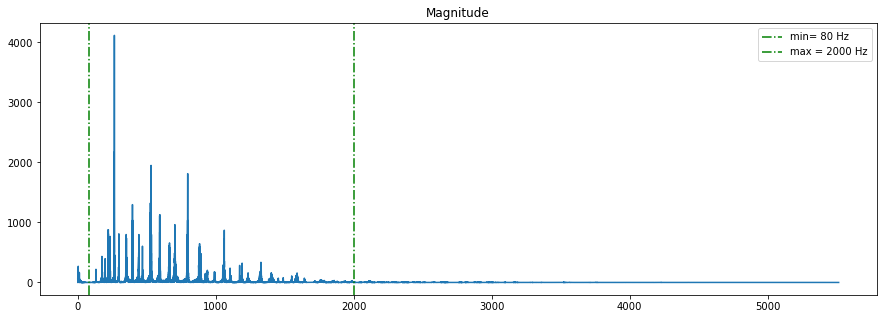

In [297]:
# Compute mel filter banks
# 1. Convert lowest and highest frequency to mel
# to check this see spectrum
#STFT = abs(np.fft.fft(signal))
#spec = librosa.display.specshow(DFT_mag)

plt.figure(figsize=(15,5))

N = len(signal)
DFT = np.fft.fft(signal)

f = np.linspace(1, sample_rate / 2, N) # convert to freq
plt.plot(f[:int(N/2) - 1], abs(DFT[:int(N/2) - 1]))
plt.title('Magnitude')
plt.axline((80,0),(80,1000), linestyle ='-.', color='green', label = 'min= 80 Hz')
plt.axline((2000,0),(2000,1000), linestyle ='-.', color='green', label = 'max = 2000 Hz')
plt.legend()

#: int(N/2) - 1


In [298]:
f_min = 20
f_max = 10000

m_min = 2595 * np.log10(1 + f_min / 700)
m_max = 2595 * np.log10(1 + f_max / 700)

In [299]:
# create # equally spaced bands:
#mel_spacing = (m_max - m_min)  / (n_mels-1)
n_mels = number_of_mels + 2 # including bounderies
mel_bands = np.linspace(m_min, m_max, n_mels)
print(mel_bands)

[  31.7484144   176.58046559  321.41251677  466.24456795  611.07661914
  755.90867032  900.7407215  1045.57277269 1190.40482387 1335.23687505
 1480.06892624 1624.90097742 1769.7330286  1914.56507979 2059.39713097
 2204.22918215 2349.06123334 2493.89328452 2638.72533571 2783.55738689
 2928.38943807 3073.22148926]


In [300]:
# convert points back to Hz
frequency_bands_target = 700 * (10**(mel_bands / 2595) - 1)
print(frequency_bands_target)


[   20.           118.7370847    231.0144637    358.68898308
   503.87212724   668.96493862   856.69772625  1070.17521965
  1312.92791493  1588.97046219  1902.86805997  2259.81195455
  2665.70529295  3127.26074932  3652.11153928  4248.93765827
  4927.60943151  5699.3507497   6576.92468997  7574.844592
  8709.61407999 10000.        ]


In [301]:
# round to nearest frequency bin as the signal is discrete
#frequency_bands = np.linspace(0, sample_rate /2 , len(STFT))
#plt.pcolormesh(STFT_db)

frequency_bands = librosa.fft_frequencies(sr=sample_rate, n_fft=2048)
#print(frequency_bands)

matched_frequency_bands = np.zeros(n_mels)
matched_frequency_index = np.zeros(n_mels)
for i in range(0,n_mels):
    matched_frequency_bands[i] = min(frequency_bands, key=lambda x:abs(x-frequency_bands_target[i]))
    matched_frequency_index[i], = np.where(frequency_bands == matched_frequency_bands[i])
print(matched_frequency_bands)

[   21.53320312   118.43261719   226.09863281   355.29785156
   506.03027344   667.52929688   861.328125    1065.89355469
  1313.52539062  1593.45703125  1905.68847656  2260.98632812
  2670.1171875   3122.31445312  3649.87792969  4252.80761719
  4931.10351562  5695.53222656  6578.39355469  7579.6875
  8710.18066406 10002.17285156]


In [302]:
matched_frequency_index
frequency_bands[569]

6126.1962890625

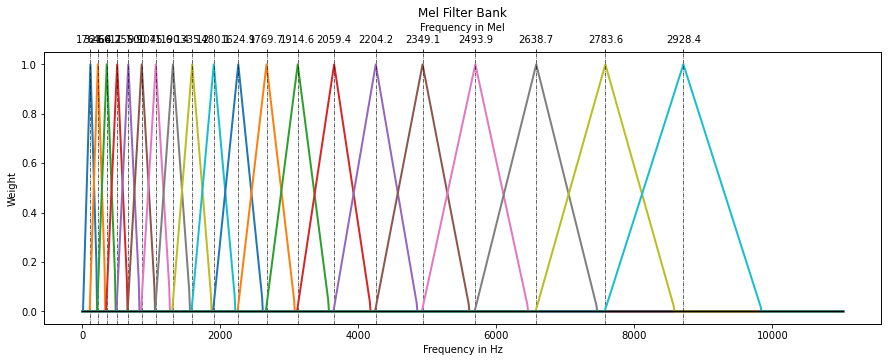

In [320]:
# create mel filter bank:
# triangular filters that ranges from previous center frequency to the next
#max_index = matched_frequency_index[-1] + (np.round( (matched_frequency_index[-1] - matched_frequency_index[-2]) / 2))

mel_filter_bank = np.zeros((number_of_mels, len(frequency_bands)))

fig = plt.figure(figsize = (15,5))
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()

for i in range(0,number_of_mels):
    # calculate range 
    window_length = 2 * int((matched_frequency_index[i+1] - matched_frequency_index[i]))
    start = int(matched_frequency_index[i])
    mel_filter_bank[i][start:start+window_length] = sp.signal.triang(window_length, False)
    
    # plot the window
    ax1.plot(frequency_bands, mel_filter_bank[i], lw = 2)
    ax1.axline((matched_frequency_bands[i+1],0),(matched_frequency_bands[i+1],1), linestyle ='-.', color='black', label = f'{np.round(mel_bands[i+1])}', lw = 0.6)

ax1.set_ylabel('Weight')
ax1.set_xlabel('Frequency in Hz')
mel_spacing = 2595 * np.log10(1 + frequency_bands / 700)
#mel_spacing = np.linspace(0, int(mel_bands[-1]), 100)

x_ticks = matched_frequency_index[1:-1]
x_labels = mel_bands[1:-1]

plt.xticks(ticks=x_ticks, labels= np.round(x_labels, 1))

#ax2.plot(mel_spacing, np.ones(len(mel_spacing)), lw = 0) # Create a dummy plot
ax2.set_xlabel('Frequency in Mel')
#ax2.set_xscale('log')
plt.title('Mel Filter Bank');

plt.plot(np.zeros(len(frequency_bands)), color='black')
#plt.grid(True, which="both")
#ax2.cla()


Mel filter bank shape = (20, 1025)
Spectrogram shape = (1025, 407)
Mel Spectrogram shape = (20, 407)


Text(0.5, 1.0, 'Mel Spectrogram')

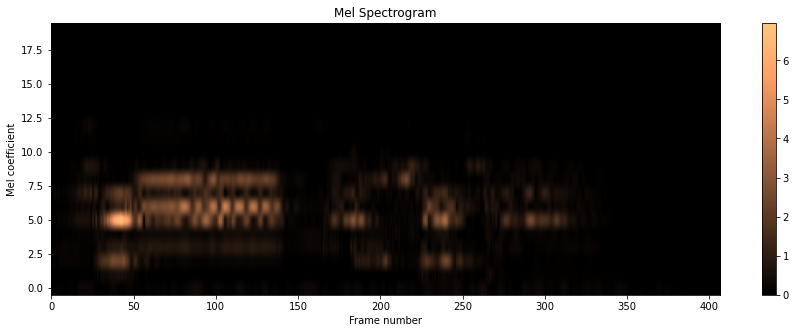

In [304]:
# Applying the mel filter bank to the spectrogram
# mel_filter_bank (M)=  (number of Mels, framesize /2 + 1)
# Spectrogram (Y) = (framesize / 2 + 1, number of frames)
# Mel spectrogram = MY

print(f'Mel filter bank shape = {np.shape(mel_filter_bank)}')
print(f'Spectrogram shape = {np.shape(STFT)}')

mel_spectrogram = np.matmul(mel_filter_bank, STFT)
print(f'Mel Spectrogram shape = {np.shape(mel_spectrogram)}')

fig = plt.figure(figsize = (15,5))
ax = fig.add_subplot(111)

img = ax.imshow(abs(mel_spectrogram), cmap='copper')
fig.colorbar(img)

ax.set_aspect('auto')
plt.gca().invert_yaxis()
ax.set_ylabel('Mel coefficient')
ax.set_xlabel('Frame number')
plt.title('Mel Spectrogram')


Text(0.5, 1.0, 'Mel Spectrogram')

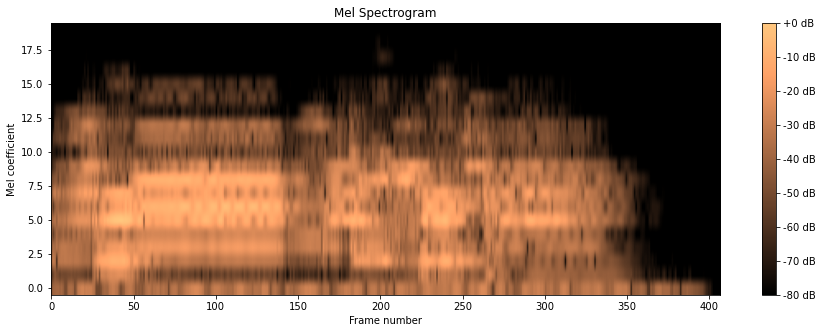

In [318]:
# final step, convert amplitude to Db: 
S_dB = librosa.amplitude_to_db(abs(mel_spectrogram), ref=np.max)

fig = plt.figure(figsize = (15,5))
ax = fig.add_subplot(111)

img = ax.imshow(S_dB, cmap='copper')
fig.colorbar(img, ax=ax, format='%+2.0f dB')

ax.set_aspect('auto')
plt.gca().invert_yaxis()
ax.set_ylabel('Mel coefficient')
ax.set_xlabel('Frame number')
plt.title('Mel Spectrogram')

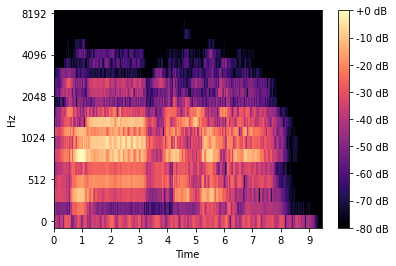

In [314]:
fig, ax = plt.subplots()
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=sample_rate,
                         fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')

[Text(0.5, 1.0, 'Mel-frequency spectrogram')]

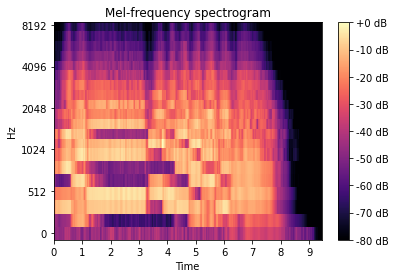

In [315]:
S = librosa.feature.melspectrogram(y=signal, sr=sample_rate, n_mels=number_of_mels,
                                    fmax=8000)
fig, ax = plt.subplots()
S_dB = librosa.power_to_db(S, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=sample_rate,
                         fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')

<h3 style = "font-size:3rem;color:darkcyan">Cepstrum</h3>
Speech can be seen as a combination of two processes: 

1. Larynx creating a pulse train, controling the pitch of your voice
2. Vocal tract (tongue, lips, cavities) that filters the sound

In the time signal these are convolved, so they both show up as the same spike in the frequency-domain when performing the fourier transform. For speeker identification you want to seperate these the vocal tract, as this information is more important for speech recognition. Cepstrum essentially differentiates the vocal tract from the larynx. Larynx will have a higher rate of change, or quefrency, as it changes faster than the vocal tract, that will have low quefrency. 

Cepstrum can be seen as the rate of change in spectral bands that is created by: 

1. Perform DFT on the time signal
2. Perform a transformation to seperate the larynx from the vocal tract. This is done by taking the log of the magnitude
3. Perform the inverse DFT to get the cepstrum


In [ ]:
# import audio file
signal , sample_rate = librosa.load('samples/Violin.wav')
signal = signal[10000:101024]

#win_size = 1024
#signal = signal[10000:10000+win_size]
N = len(signal)


# take snippet

# take DFT of fragment

DFT = np.fft.fft(signal)

DFT_log_pow = np.log10(abs(DFT))

C = np.fft.ifft(DFT_log_pow)

In [ ]:
plt.figure(figsize = (15,10))

plt.subplot(2,2,1)
plt.plot(signal)

plt.subplot(2,2,2)
plt.plot(abs(DFT[:int(np.round(N / 2) - 1)]))

plt.subplot(2,2,3)
plt.plot(DFT_log_pow[:int(np.round(N / 2) - 1)])

plt.subplot(2,2,4)
plt.plot(np.real(C[::-1] / N))


In [ ]:
signal = signal[10000:101024]

N = len(signal)
print(N)
DFT = np.fft.fft(signal)

iDFT = np.fft.fft(DFT)

In [ ]:
plt.figure(figsize = (15,10))
plt.subplot(2,2,1)
plt.plot(signal)

plt.subplot(2,2,2)

plt.plot(abs(DFT[:int(np.round(N / 2) - 1)]))

plt.subplot(2,2,3)
plt.plot(np.real(iDFT[::-1]) / N)
plt.plot(np.imag(iDFT))